Document Modelling
=======

This looks at encoding words as fixed length vectors based on either:
* The end hidden state after applying a sequence of character embeddings to a recurrent neural network (RNN) (LSTM or GRU); or
* Applying a convolutional neural network (CNN) to a series of character embeddings.

Because we need to generate a custom architecture I think we will need to use Tensorflow directly rather than Keras.

The working architecture diagram is here:  

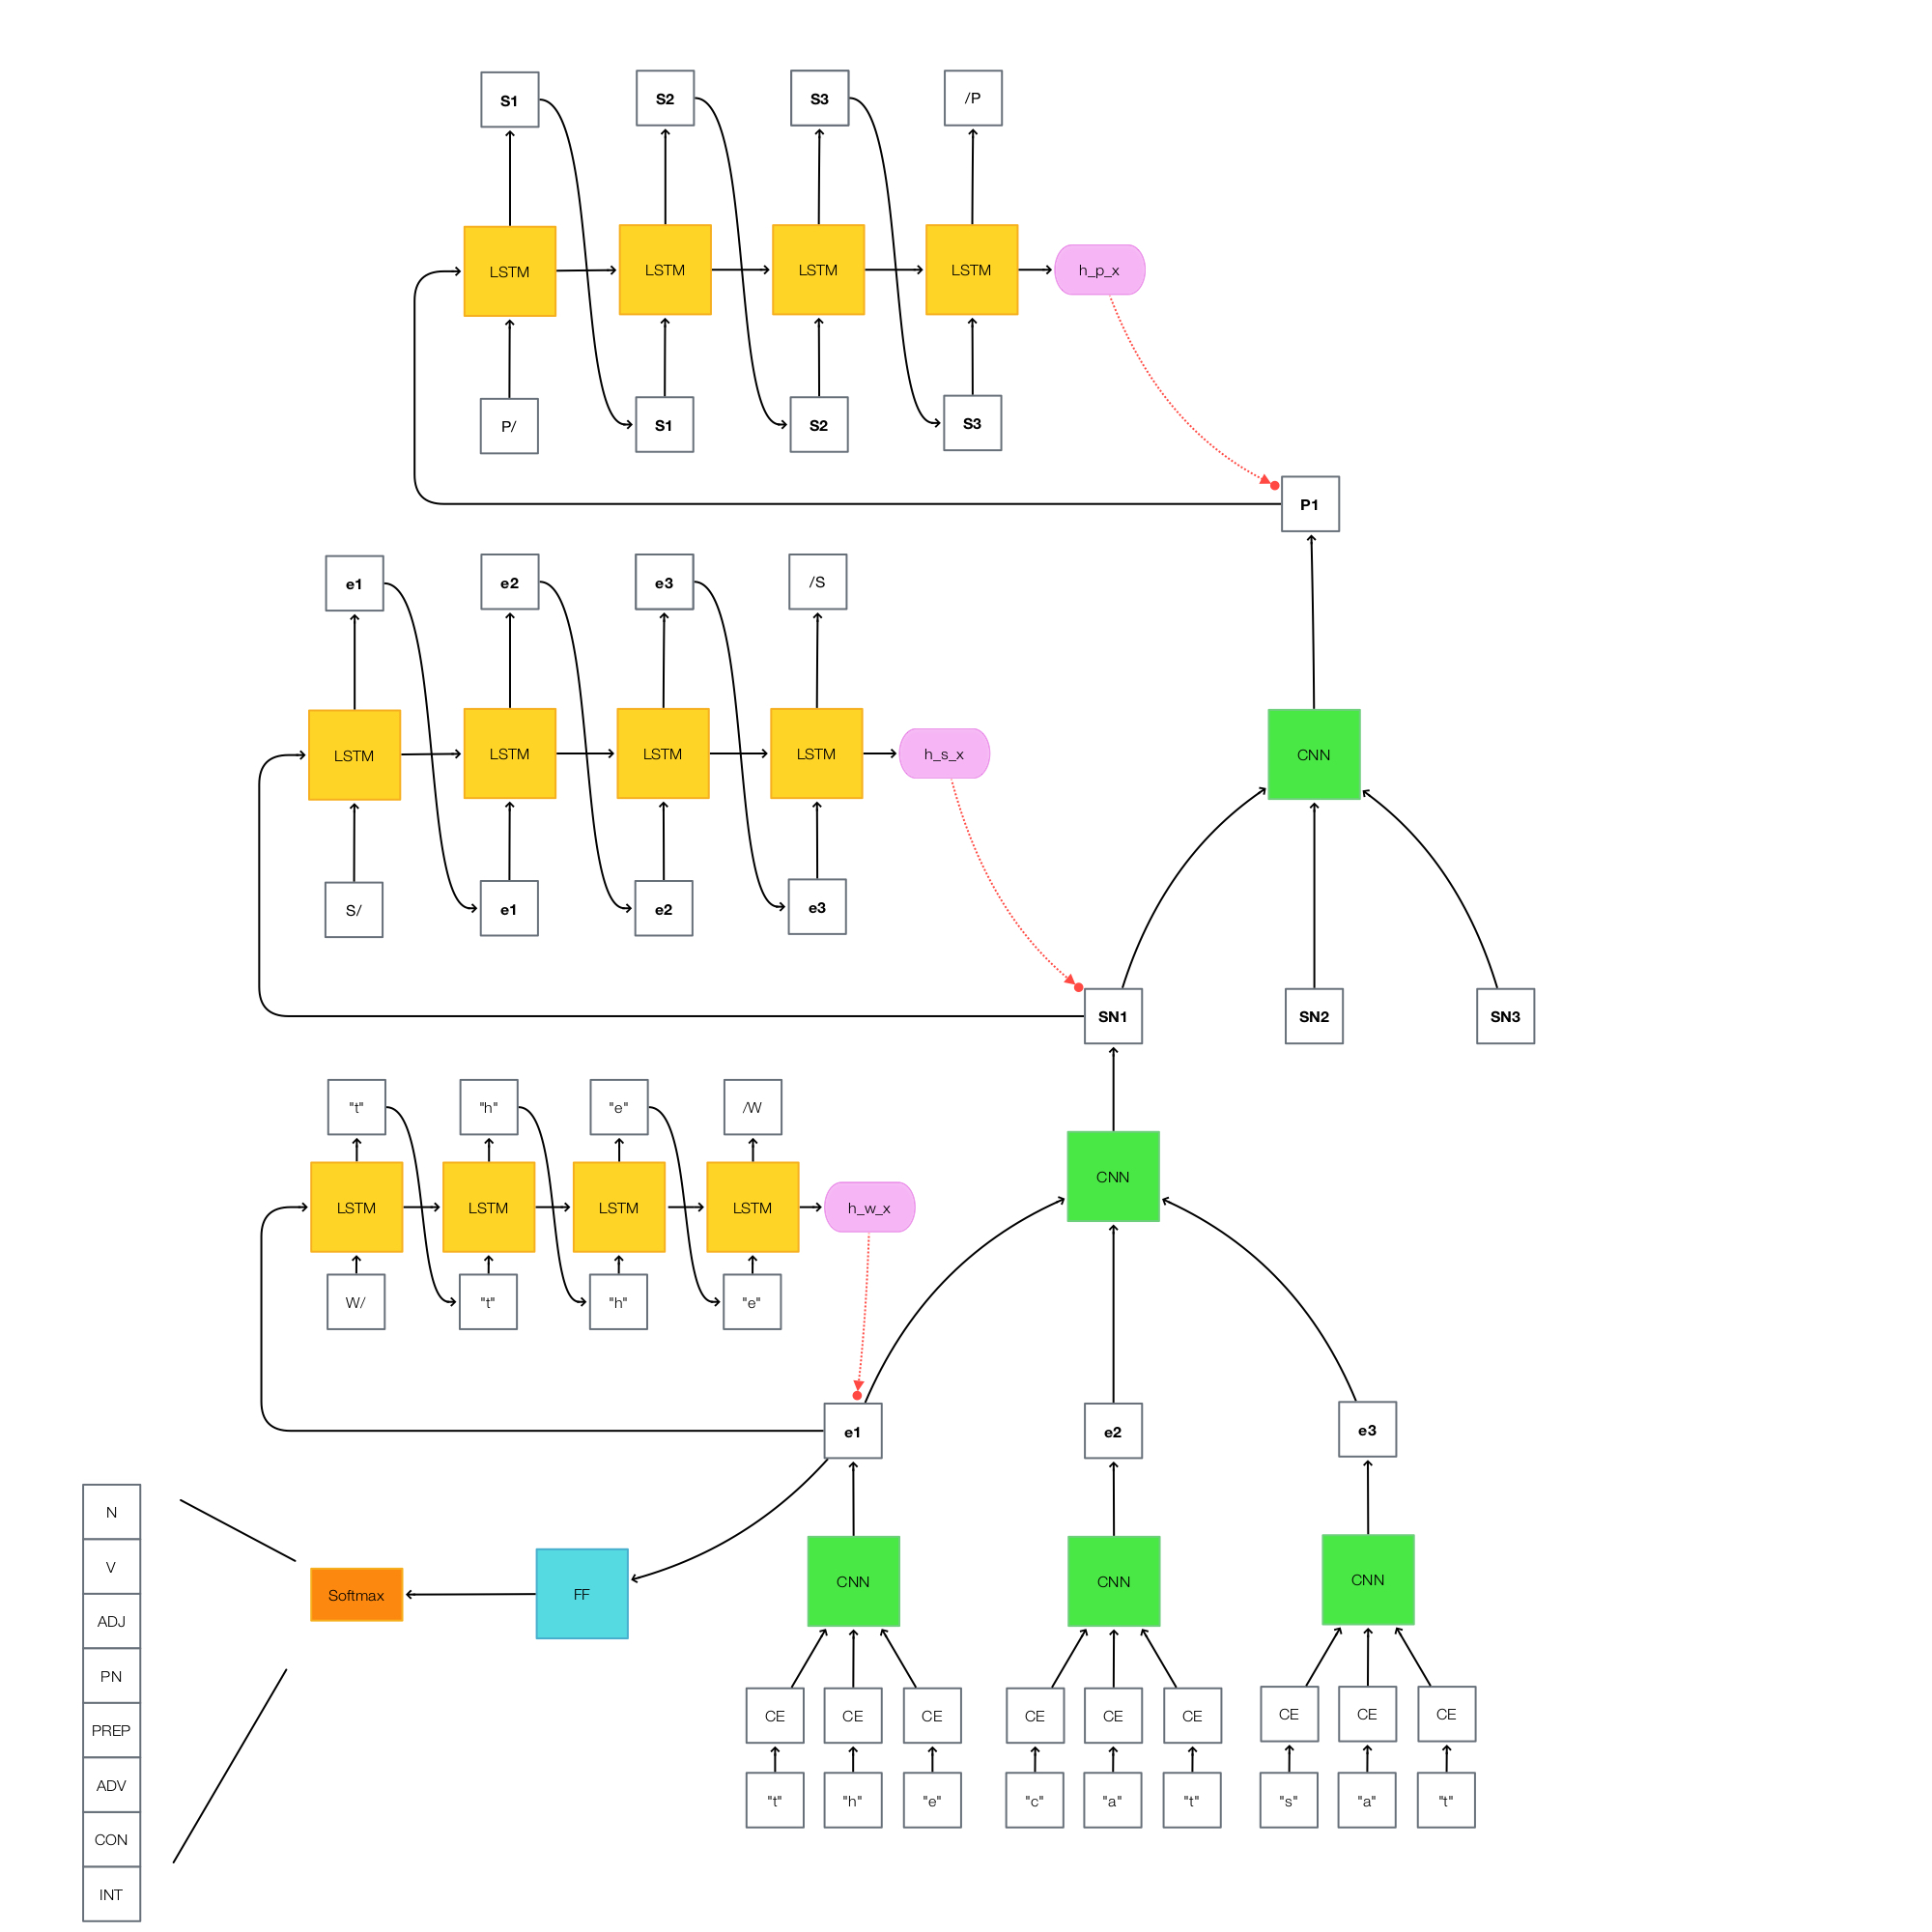

We have a (patent) document $\boldsymbol D$.  

The document can be represented as a sequence of paragraphs:  
$$\boldsymbol D = (\boldsymbol p_1, \boldsymbol p_2, ..., \boldsymbol p_N)$$
where $N$ equals the number of paragraphs in the document.

Each paragraph can be represented as a sequence of sentences:
$$\boldsymbol p_i = (\boldsymbol s_1, \boldsymbol s_2, ..., \boldsymbol s_{Mi})$$
where $M_i$ equals the number of sentences in paragraph $i$.

Each sentence can then be represented as a sequence of words:
$$\boldsymbol s_i = (\boldsymbol w_1, \boldsymbol w_2, ..., \boldsymbol w_{Ki})$$
where $K_i$ equals the number of words in sentence $i$.

Finally each word can  be represented as a sequence of characters:
$$\boldsymbol w_i = (c_1, c_2, ..., c_{Li})$$
where $L_i$ equals the number of characters in word $i$.

---
The model is set out above. In practice, all we have is $$\boldsymbol D = (c_1, c_2, ..., c_T)$$ where $T$ is the number of characters in the text stream.  

The form of our characters depends on our text encoding scheme. Python uses unicode encoding. Characters can be encoded using 8, 16 or 32-bit encoding schemes. Python has an ord( ) function that returns an integer value for a character. An analysis of 100,000 patent publications returns a highest integer value of 120138 and a dimensionality of 607 unique characters.  

We apply some pre-processing to reduce the dimensionality of our character set. We convert accented characters into their unaccented equivalents. We replace capital characters with a tuple of ("< CAPITAL >", lowercase_char), i.e. prepend a special control token indicating a capital letter.

In [3]:
from patentdata.models.chardict import CharDict

cd = CharDict()
print("This is our working character set: {0}".format(list(cd.forward_dict.keys())))
print("There are {0} characters in our character set.".format(cd.vocabulary_size))

This is our working character set: ['+', '9', '>', 'a', '<W>', '_', 'n', '{', 'l', 'f', '<', 'p', 'c', '\\', '6', 'x', 'o', 'j', '!', 'e', '0', ']', '&', 's', '</S>', '`', '^', '~', '</P>', '8', 'w', '\n', '"', '4', '|', '(', '</DOC>', '#', '-', '[', '*', '5', '3', "'", '\t', '/', '?', 'r', 'y', '\r', 'i', '.', 'b', 'v', '%', ';', ')', '=', 'g', '<S>', 'k', '<P>', 'h', 'z', 'u', '<DOC>', '<CAPITAL>', ',', ' ', 'd', '</W>', 'm', '@', '}', '2', 'q', ':', 't', '$', '<OOD>', '1', '7']
There are 82 characters in our character set.


We'll actually need to set 0 as the < PAD > token.

## Encoding

At a high level in our document model we have an encoder for each level of hierarchy. For example, we have:
* **Embedding** - for encoding each character;
* **CharEncoder** - for encoding a sequence of characters as a word (embedding) vector;
* **WordEncoder** - for encoding a sequence of word (embedding) vectors as a sentence (embedding) vector;
* **SentEncoder** - for encoding a sequence of sentence (embedding) vectors as a paragraph (embedding) vector; and
* **ParaEncoder** - for encoding a sequence of paragraph (embedding) vectors as a document (embedding) vector.

In [1]:
class Encoder(object):
    """ Abstract class to encode a variable length sequence."""
    def __init__(self, output_dim):
        self.output_dim = output_dim
        pass
    
    def encode(self, sequence):
        """Encode a sequence.
        
        :param sequence: array of values"""
        
        fixed_length_output = 0*output_dim
        return fixed_length_output

In [ ]:
class CNNEncoder(Encoder):
    """ Encodes a document into a fixed length representation using a CNN. """
    
    def __init__(self, output_dim, filter_sizes, num_filters):
        Encoder.__init__(output_dim)
        self.filter_sizes = filter_sizes
        self.num_filters = num_filters
        
    def __concat_seq__(self, sequence):
        """ Concatenate an input sequence to generate a matrix. """
        
    
    def encode(self, sequence):
        """ Encode a single sequence - we will batch later.
        
        sequence is an NP array of embeddings.
        Each embedding is assumed to be of a fixed dimension.
        """
        element_length = 0
        # Create a convolution + maxpool layer for each filter size
        pooled_outputs = []
        for i, filter_size in enumerate(self.filter_sizes):
            with tf.name_scope("conv-maxpool-%s" % filter_size):
                # Convolution Layer
                # Filters are applied via a weight matrix - each filter outputs one value?
                # One weight matrix per filter size - we can have multiple filters per filter size
                # Each filter per filter size outputs an entry
                # filter = [height, width, channels, ]
                filter_shape = [filter_size, element_length, 1, self.num_filters]
                # K is 4d tensor e.g. [3, 128, 1, 128] - values for these filters are learned - 1 = 1D
                K = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="K")
                # bias is e.g. of length 128
                b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b")
                # This is effectively performing 1D convolution in parallel for a given filter size for 
                conv = tf.nn.conv2d(
                    self.embedded_chars_expanded,
                    K,
                    strides=[1, 1, 1, 1],
                    padding="VALID",
                    name="conv")
                #conv has size [batch_size, sequence_length - filter_size + 1, 1, num_filters]
                # Apply nonlinearity
                h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")
                # Maxpooling over the outputs - all filters for each size are max pooled
                # kernel size = [1, 30-3+1, 1, 1] - one value for each dimension of h
                # We max pool over the sequence_length - filter_size + 1 to return an output of
                # [batch_size, 1, 1, num_filters]
                pooled = tf.nn.max_pool(
                    h,
                    ksize=[1, sequence_length - filter_size + 1, 1, 1],
                    strides=[1, 1, 1, 1],
                    padding='VALID',
                    name="pool")
                pooled_outputs.append(pooled)

        # Combine all the pooled features
        # Number of filters = num_per_each_size * number_of_different_sizes
        num_filters_total = num_filters * len(filter_sizes)
        # Concatenate all the outputs for each filter size
        self.h_pool = tf.concat(pooled_outputs, 3)
        # Flatten into one dimension
        self.h_pool_flat = tf.reshape(self.h_pool, [-1, num_filters_total])

        # Add dropout
        with tf.name_scope("dropout"):
            self.h_drop = tf.nn.dropout(self.h_pool_flat, self.dropout_keep_prob)
        

(Aside: fixed dimensions seem wasteful for short sequences but not powerful enough for long sequences. I guess the idea is you build longer sequences from composition. 

Composition is performed based on variable length chunks but is driven by frequency of use. )

In [ ]:
sequence_length, num_classes, vocab_size,
      embedding_size, filter_sizes, num_filters,

In one proposed model each of these encoders is a CNN:
* **CharCNN** - for encoding a sequence of characters as a word (embedding) vector;
* **WordCNN** - for encoding a sequence of word (embedding) vectors as a sentence (embedding) vector;
* **SentCNN** - for encoding a sequence of sentence (embedding) vectors as a paragraph (embedding) vector;
* **ParaCNN** - for encoding a sequence of paragraph (embedding) vectors as a document (embedding) vector


Each may be based on a common abstract **CNN** class that takes a plurality of embeddings.

We have a number of recurrent neural networks (RNNs) in the form of long short term memory (LSTM) cells (or just LSTMs).

* **CharLSTM** - for decoding a word embedding vector to produce a sequence of word characters;
* **WordLSTM** - for decoding a sentence embedding vector to produce a sequence of word embeddings;
* **SentLSTM** - for decoding a paragraph embedding vector to produce a sequence of sentence embeddings; and
* **ParaLSTM** - for decoding a document embedding vector to produce a sequence of paragraph embeddings.

These will all be variations of a basic abstract **LSTM** class.

---
Our lowest model level is character embedding. 

The input into the character embedding (CE) is an integer index for the character: $c_i \in [0, 81]$. In the theory this is represented as a one-hot encoding, i.e. an array of length 82 where each array element represents one of the integers. 

Character embedding converts the one-hot encoding of the integer index into a vector $\textbf{ce}_i$ of length $d_{ce}$. This is performed by multiplying the one-hot encoding by a weight matrix $\textbf{CE}$, i.e.:

$$\textbf{ce}_i = \textbf{onehot}_i^T \textbf{CE}$$

Possibly choices for $d_{ce}$ are 3, 8, 16, 32, 64 or 128. 8 or 16 seem best.

$\textbf{CE} \in \mathbb{R}^{|V| \times d_{ce}}$, where $V$ is the vocabulary of characters (i.e. our character set).

For a nice explanation of the embedding process see this blog post: https://blog.acolyer.org/2016/04/21/the-amazing-power-of-word-vectors/
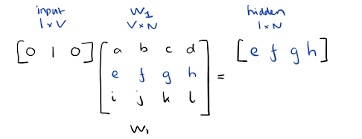

---

The next stage is to apply a convolutional neural network (CNN) to a set of character embeddings for a word.  

A first issue here is how do we define what a 'word' is if we only have a stream of characters. 

The answer is that we have (imperfect) segmentation functions such that: $$para\_segment(\boldsymbol D) = (\boldsymbol p_1, \boldsymbol p_2, ..., \boldsymbol p_N)$$ $$sent\_segment(\boldsymbol p_i) = (\boldsymbol s_1, \boldsymbol s_2, ..., \boldsymbol s_{Mi})$$ $$word\_segment(\boldsymbol s_i) = (\boldsymbol w_1, \boldsymbol w_2, ..., \boldsymbol w_{Ki})$$

Through this pipeline of functions we can retrieve a sequence of words for each of a sequence of sentences. For each word we thus have access to a sequence of characters: $\boldsymbol w_i = (c_1, c_2, ..., c_{Li})$.

At this stage we also need to introduce some control characters to indicate the start of a word and an end of a word. These are "< W >" and "< /W >" in the character set above. Hence, we have $\boldsymbol w_i = (<W>, c_1, c_2, ..., c_{Li}, </W>)$.

After applying our character embeddings to each character in the previous step our word is now represented by a sequence of character embeddings:

$$\boldsymbol w^e_i = (\textbf{ce}_1, \textbf{ce}_2, ..., \textbf{ce}_{Li+2})$$

where $\textbf{ce}_i \in \mathbb{R}^{1 \times d_{ce}}$.

To get a matrix representing the $i$th word we can concatenate these character embeddings:

$$\textbf{W}_i = [\textbf{ce}_1, \textbf{ce}_2, ..., \textbf{ce}_{Li+2}]$$

where $\textbf{W}_i \in \mathbb{R}^{d_{ce} \times L_{i+2}}$. $\textbf{W}_i$ has a varying number of rows but a fixed number of columns.

$\textbf{W}_i$ then forms the input for our CNN. The CNN is constructed from a number of 1-d convolutional layers. The convolution is 1 dimensional as it is only applied in the temporal dimension (i.e. to the rows of $W$ representing a stride along the sequence of characters - striding across the dimension of the character embedding would not really be useful). A convolution applies a sliding window of length $l$ and width $d_{ce}$ (i.e. of the embedding size). 

#### Understanding Filters as Used by Tensorflow

This is a great stackoverflow answer: https://stackoverflow.com/questions/34619177/what-does-tf-nn-conv2d-do-in-tensorflow .

This is useful in combination with the Tensorflow docs - https://www.tensorflow.org/api_docs/python/tf/nn/conv2d.

For our input we have a [a, b, c, d] tensor - i.e. a x b x c x d.  
- a is the number of input 'images' or examples;
- b is the input width;
- c is the input height; and
- d is the number of input channels.

For the filter you also have a [o, p, q, r] tensor - i.e. o x p x q x r.  
- o is the filter width;
- p is the filter height;
- q is the number of channels (from the input - i.e. input channels); and
- r is the number of filters (or output channels).

q basically has to match d. r - the number of output channels is equal to the number of filters you want - basically a different filter of width * height will be created and the output of each filter corresponds to a separate channel.

I think we could use the conv1d Tensorflow method. However, it is more efficient to use conv2d. Maybe we can initially define in 1D, work out how that works, then understand how we can use 2D for efficiency over our batches.  

In 1D the input is in the form:  [batch, in_width, in_channels] and the filter is of the form: [filter_width, in_channels, out_channels]. The conv1d function calls conv2d anyway.

Generally, for a word $w$, a feature $f_i$ is generated by: 

$$f_i(w) = g(k.{ce_{i...i+l-1}} +b)$$

where $b \in \mathbb{R}^{1 \times num\_filters}$ is a bias term and $k$ is a filter of length $l$.

[This may not be right].

The CNN can be thought of as a function on $\textbf{W}_i$: $$\textbf{we}_i = CharCNN(\textbf{W}_i)$$

Hyper-parameters for the CNN include the number of filters per filter length and the different filter lengths to apply. We can concatenate the output for each filter length.

---
When training the implementations require a maximum sequence length for our words. From some preliminary analysis, the longest real words in our dataset are around 20 characters long:  
```
Our longest filtered token for top 10000 tokens is interrelationship with a length of 17.

Our longest unfiltered token for top 250 tokens is configuration with a length of 13
Our longest unfiltered token for top 500 tokens is communications with a length of 14
```

Above this there were some longer hyphenated\slashed words. If we adapt our word segmentation function to split hyphenated and slashed words into three 'word' tokens instead of one (e.g. "computer", "-", "implemented" instead of "computer-implemented", we can avoid these. Our maximum length is then still around 20 characters.
```
Our longest unfiltered token for top 1000 tokens is computer-readable with a length of 17
Our longest unfiltered token for top 2000 tokens is three-dimensional with a length of 17
Our longest unfiltered token for top 3000 tokens is computer-implemented with a length of 20
Our longest unfiltered token for top 10000 tokens is transmission/reception with a length of 22
```

We do see longer words in our data. Above this our words were concatenations or made-up sequences. 
```
Our longest filtered token for top 100000 tokens is businesstransactiondocumentitemhierarchyrelationshiptypecod with a length of 59



Input into the lower level CNN is a concatenation of the character embeddings for the word: a matrix with a set number of rows = to the character embedding dimensionality and a number of columns = number of characters in the word. The latter is variable according to the word; the former is of fixed size.  

e1 is a fixed length word embedding vector.

---
Aside - can we use our LSTM decoder for segmentation? Use it to predict /W characters.

Issue of softmax sampling for large vocubularies - is there any way we can break down the dimensionality of the output and use e.g. beam search to compose a predicted softmax output from a series of individual predictions?

Thus, we combine the word and character-level models by feeding a word-level LSTM hidden state h into a small
LSTM that predicts the target word one character at a time (see Figure 1(c)). In order to make the whole process reasonably efficient, we train the standard LSTM model until convergence, freeze its weights, and replace the standard word-level Softmax layer with the aforementioned character-level LSTM.

This seems a good idea. We take the hidden state that represents our word and feed it into a decoder. We then only need to work at the character level, which solves the high vocabulary dimensionality issue.

## Decoding

We have a number of recurrent neural networks (RNNs) in the form of long short term memory (LSTM) cells (or just LSTMs).

* **CharLSTM** - for decoding a word embedding vector to produce a sequence of word characters;
* **WordLSTM** - for decoding a sentence embedding vector to produce a sequence of word embeddings;
* **SentLSTM** - for decoding a paragraph embedding vector to produce a sequence of sentence embeddings; and
* **ParaLSTM** - for decoding a document embedding vector to produce a sequence of paragraph embeddings.

These will all be variations of a basic abstract **LSTM** class.

Each LSTM will take a sequence as input and output a sequence as output:


* **CharLSTM**:
    * Input: word character sequence as integers [0, 12, 23, 82, 23] with extra word start character at 0.
    * Output: word character sequence shifted by 1 character to the right [12, 23, 82, 23, 1] with extra word end character at end.
    * Labels: as output but actual values from data.
    * Loss: sequence loss comparing Output and Labels.
    * Starting hidden state: word embedding.
   
   
* **WordLSTM**:
    * Input: word embedding sequence for sentence as vectors [< S >, [0.1,0.2,0.1], [0.9,0.3,0.05], [0.9,0.2,0.1], [0.1,0.8,0.5]] with extra sentence-start word embedding at 0.
    * Output: word embedding sequence for sentence shifted by 1 character to the right [[0.1,0.2,0.1], [0.9,0.3,0.05], [0.9,0.2,0.1], [0.1,0.8,0.5], < /S >] with extra sentence-end word embedding at end.
    * Labels: same format as output. Each entry is generated by running character data for the actual word through encoding WordCNN. This takes as original input a sentence from the data.
    * Loss: sequence loss comparing Output and Labels.
    * Starting hidden state: sentence embedding.
    * Question: does TF pad with 0 vector or 0 scalar?
    * Question: how do we evalutate loss between vectors?
    
   
* **SentLSTM**:
    * Input: sentence embedding sequence as vectors [< P >, [0.1,0.2,0.1], [0.9,0.3,0.05], [0.9,0.2,0.1], [0.1,0.8,0.5]] with extra paragraph-start embedding at 0.
    * Output: sentence embedding sequence shifted by 1 element to the right [[0.1,0.2,0.1], [0.9,0.3,0.05], [0.9,0.2,0.1], [0.1,0.8,0.5], < /P >] with extra paragraph-end element at end.
    * Labels: as output but actual values from data. This is generated by running the character data through the CharCNN then running that encoding through the WordCNN encoders then through the SentCNN. This takes as original input a paragraph from the data.
    * Loss: sequence loss comparing Output and Labels.
    * Starting hidden state: paragraph embedding.
    * Question: does TF pad with 0 vector or 0 scalar?
    
    
* **ParaLSTM**:
    * Input: paragraph embedding sequence as vectors [< D >, [0.1,0.2,0.1], [0.9,0.3,0.05], [0.9,0.2,0.1], [0.1,0.8,0.5]] with extra document-start element at 0.
    * Output: paragraph embedding sequence shifted by 1 element to the right [[0.1,0.2,0.1], [0.9,0.3,0.05], [0.9,0.2,0.1], [0.1,0.8,0.5], < /D >] with extra document-end element at end.
    * Labels: as output but actual values from data. This is generated by running the character data through the CharCNN then running that encoding through the WordCNN encoders. Then running that through the SentCNN encoders. Then running that through a ParaCNN. This takes as original input the set of paragraphs from the data.
    * Loss: sequence loss comparing Output and Labels.
    * Starting hidden state: document embedding.
    * Question: does TF pad with 0 vector or 0 scalar?

##### Insights

There is reuse between hidden states and labels.

Normal LSTM language models have to store information to predict the whole document structure. Here they individually predict the word structure, sentence structure, paragraph structure and document structure.



## Loss Function

We are looking at a loss function with multiple components:
* Sum (weighted) or the losses from each of the LSTMs - comparison of output with labels.

Our clock is an the character level 



The approach proposed in (Ling et al., 2015) builds word
embeddings using bidirectional LSTMs (Schuster & Paliwal,
1997; Graves & Schmidhuber, 2005) over the characters.
The recurrent networks process sequences of characters
from both sides and their final state vectors are concatenated.
The resulting representation is then fed to a Neural
Network. This model achieved very good results on a partof-speech
tagging task.

This is a good bit of code for working out how to build an object-orientated LSTM model https://github.com/tensorflow/models/blob/master/tutorials/rnn/ptb/ptb_word_lm.py

Also here: http://www.wildml.com/2016/08/rnns-in-tensorflow-a-practical-guide-and-undocumented-features/

In [3]:
sequences = [[1, 2, 3], [4, 5, 1], [1, 2]]
label_sequences = [[0, 1, 0], [1, 0, 0], [1, 1]]

list(zip(sequences, label_sequences))

[([1, 2, 3], [0, 1, 0]), ([4, 5, 1], [1, 0, 0]), ([1, 2], [1, 1])]

In [ ]:
# https://medium.com/towards-data-science/lstm-by-example-using-tensorflow-feb0c1968537
def LSTM(x, weights, biases):

    # reshape to [1, n_input]
    x = tf.reshape(x, [-1, n_input])

    # Generate a n_input-element sequence of inputs
    # (eg. [had] [a] [general] -> [20] [6] [33])
    x = tf.split(x,n_input,1)

    # 1-layer LSTM with n_hidden units.
    rnn_cell = rnn.BasicLSTMCell(n_hidden)

    # generate prediction
    outputs, states = rnn.static_rnn(rnn_cell, x, dtype=tf.float32)

    # there are n_input outputs but
    # we only want the last output
    return tf.matmul(outputs[-1], weights['out']) + biases['out']

## CNN

Starting from here: https://arxiv.org/pdf/1508.06615.pdf .

Generate a matrix for each word where each ith column of the matrix is the ith character embedding vector.

In this Google paper - https://arxiv.org/pdf/1602.02410.pdf character CNNs allow good nearest neighbour guesses for words with fewer parameters.

See this nice Tensorflow implementation - https://github.com/dennybritz/cnn-text-classification-tf/blob/master/text_cnn.py.

> "VALID" padding means that we slide the filter over our sentence without padding the edges, performing a narrow convolution that gives us an output of shape [1, sequence_length - filter_size + 1, 1, 1]. 

I think we want valid padding - we want the filter to abut our word start and end rather than flow over.

As per Tensorflow docs:
>For the 'VALID' padding, the output height and width are computed as:  
out_height = ceil(float(in_height - filter_height + 1) / float(strides[1]))
out_width  = ceil(float(in_width - filter_width + 1) / float(strides[2]))

Hence, we have a width of 1 as our filter width is the same as our input (embedding) width.

In [1]:
# Character Embedding layer - we can constrain vocab_size
embedding_size = 16
vocab_size = 82 # See above

# self.input_x - has max length sequence length - how do we truncate words?

with tf.device('/cpu:0'), tf.name_scope("embedding"):
    # Generate weights for embedding matrix
    self.CE = tf.Variable(
                    tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0),
                    name="CE")
    # Convert input_x to embedded version using an embedding lookup - this does multiple 
    # characters in the input at once
    self.embedded_chars = tf.nn.embedding_lookup(self.W, self.input_x)
    # Add another element / dimension to the end of embedded_chars - why do we do this?
    self.embedded_chars_expanded = tf.expand_dims(self.embedded_chars, -1)

NameError: name 'tf' is not defined

In [ ]:
# Code is from Denny Britz's Github repo - I've annotated below to understand.
import tensorflow as tf
import numpy as np


class TextCNN(object):
    """
    A CNN for text classification.
    Uses an embedding layer, followed by a convolutional, max-pooling and softmax layer.
    """
    def __init__(
      self, sequence_length, num_classes, vocab_size,
      embedding_size, filter_sizes, num_filters, l2_reg_lambda=0.0):
        
        # defaults
        # filter_sizes = default '3,4,5'
        # num_filters = 128
        # embedding_size = 128
        
        # Placeholders for input, output and dropout
        # Input is integer of length any and width equal to sequence_length, i.e. max length of character sequence 
        # In our case, the first dimension is the batch size, and using None allows the network to handle arbitrarily sized batches.
        self.input_x = tf.placeholder(tf.int32, [None, sequence_length], name="input_x")
        self.input_y = tf.placeholder(tf.float32, [None, num_classes], name="input_y")
        self.dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")

        # Keeping track of l2 regularization loss (optional)
        l2_loss = tf.constant(0.0)

        # Embedding layer
        with tf.device('/cpu:0'), tf.name_scope("embedding"):
            # Generate weights for embedding matrix
            self.W = tf.Variable(
                tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0),
                name="W")
            # Convert input_x to embedded version using an embedding lookup
            self.embedded_chars = tf.nn.embedding_lookup(self.W, self.input_x)
            #The result of the embedding operation is a 3-dimensional tensor of shape [None, chars_in_word_length, embedding_size].
            # Where None allows variable batch sizes
            # Add another element / dimension to the end of embedded_chars - why do we do this? Adds the "channel" dimension
            # We have a channel of 1 - conv2d expects [batchsize, x, y, channels]
            self.embedded_chars_expanded = tf.expand_dims(self.embedded_chars, -1)
            
            # The output is the embedding matrix for the sequence of characters - this is the middle of our con input -
            # as the first array entry we have batch size and as our last entry the number of channels

        # Create a convolution + maxpool layer for each filter size
        pooled_outputs = []
        for i, filter_size in enumerate(filter_sizes):
            with tf.name_scope("conv-maxpool-%s" % filter_size):
                # Convolution Layer
                # Filters are applied via a weight matrix - each filter outputs one value?
                # One weight matrix per filter size - we can have multiple filters per filter size
                # Each filter per filter size outputs an entry
                # filter = [height, width, channels, ]
                filter_shape = [filter_size, embedding_size, 1, num_filters]
                # W is 4d tensor e.g. [3, 128, 1, 128] - values for these filters are learned - 1 = 1D
                W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
                # bias is e.g. of length 128
                b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b")
                # This is effectively performing 1D convolution in parallel for a given filter size for 
                conv = tf.nn.conv2d(
                    self.embedded_chars_expanded,
                    W,
                    strides=[1, 1, 1, 1],
                    padding="VALID",
                    name="conv")
                #conv has size [batch_size, sequence_length - filter_size + 1, 1, num_filters]
                # Apply nonlinearity
                h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")
                # Maxpooling over the outputs - all filters for each size are max pooled
                # kernel size = [1, 30-3+1, 1, 1] - one value for each dimension of h
                # We max pool over the sequence_length - filter_size + 1 to return an output of
                # [batch_size, 1, 1, num_filters]
                pooled = tf.nn.max_pool(
                    h,
                    ksize=[1, sequence_length - filter_size + 1, 1, 1],
                    strides=[1, 1, 1, 1],
                    padding='VALID',
                    name="pool")
                pooled_outputs.append(pooled)

        # Combine all the pooled features
        # Number of filters = num_per_each_size * number_of_different_sizes
        num_filters_total = num_filters * len(filter_sizes)
        # Concatenate all the outputs for each filter size
        self.h_pool = tf.concat(pooled_outputs, 3)
        # Flatten into one dimension
        self.h_pool_flat = tf.reshape(self.h_pool, [-1, num_filters_total])

        # Add dropout
        with tf.name_scope("dropout"):
            self.h_drop = tf.nn.dropout(self.h_pool_flat, self.dropout_keep_prob)

        # HERE is where we would feed h_drop into the LSTM to decode the word characters 
            
        # Final (unnormalized) scores and predictions
        with tf.name_scope("output"):
            # This is the output projection from the flatten, dropped max-pool output to scores
            W = tf.get_variable(
                "W",
                shape=[num_filters_total, num_classes],
                initializer=tf.contrib.layers.xavier_initializer())
            b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            self.scores = tf.nn.xw_plus_b(self.h_drop, W, b, name="scores")
            self.predictions = tf.argmax(self.scores, 1, name="predictions")

        # CalculateMean cross-entropy loss
        with tf.name_scope("loss"):
            losses = tf.nn.softmax_cross_entropy_with_logits(logits=self.scores, labels=self.input_y)
            self.loss = tf.reduce_mean(losses) + l2_reg_lambda * l2_loss

        # Accuracy
        with tf.name_scope("accuracy"):
            correct_predictions = tf.equal(self.predictions, tf.argmax(self.input_y, 1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"), name="accuracy")

In [ ]:
# Training code

import tensorflow as tf
import numpy as np
import os
import time
import datetime
import data_helpers
from text_cnn import TextCNN
from tensorflow.contrib import learn

# Parameters
# ==================================================

# Data loading params
tf.flags.DEFINE_float("dev_sample_percentage", .1, "Percentage of the training data to use for validation")
tf.flags.DEFINE_string("positive_data_file", "./data/rt-polaritydata/rt-polarity.pos", "Data source for the positive data.")
tf.flags.DEFINE_string("negative_data_file", "./data/rt-polaritydata/rt-polarity.neg", "Data source for the negative data.")

# Model Hyperparameters
tf.flags.DEFINE_integer("embedding_dim", 128, "Dimensionality of character embedding (default: 128)")
tf.flags.DEFINE_string("filter_sizes", "3,4,5", "Comma-separated filter sizes (default: '3,4,5')")
tf.flags.DEFINE_integer("num_filters", 128, "Number of filters per filter size (default: 128)")
tf.flags.DEFINE_float("dropout_keep_prob", 0.5, "Dropout keep probability (default: 0.5)")
tf.flags.DEFINE_float("l2_reg_lambda", 0.0, "L2 regularization lambda (default: 0.0)")

# Training parameters
tf.flags.DEFINE_integer("batch_size", 64, "Batch Size (default: 64)")
tf.flags.DEFINE_integer("num_epochs", 200, "Number of training epochs (default: 200)")
tf.flags.DEFINE_integer("evaluate_every", 100, "Evaluate model on dev set after this many steps (default: 100)")
tf.flags.DEFINE_integer("checkpoint_every", 100, "Save model after this many steps (default: 100)")
tf.flags.DEFINE_integer("num_checkpoints", 5, "Number of checkpoints to store (default: 5)")
# Misc Parameters
tf.flags.DEFINE_boolean("allow_soft_placement", True, "Allow device soft device placement")
tf.flags.DEFINE_boolean("log_device_placement", False, "Log placement of ops on devices")

FLAGS = tf.flags.FLAGS
FLAGS._parse_flags()
print("\nParameters:")
for attr, value in sorted(FLAGS.__flags.items()):
    print("{}={}".format(attr.upper(), value))
print("")


# Data Preparation
# ==================================================

# Load data
print("Loading data...")
x_text, y = data_helpers.load_data_and_labels(FLAGS.positive_data_file, FLAGS.negative_data_file)

# Build vocabulary
max_document_length = max([len(x.split(" ")) for x in x_text])
vocab_processor = learn.preprocessing.VocabularyProcessor(max_document_length)
x = np.array(list(vocab_processor.fit_transform(x_text)))

# Randomly shuffle data
np.random.seed(10)
shuffle_indices = np.random.permutation(np.arange(len(y)))
x_shuffled = x[shuffle_indices]
y_shuffled = y[shuffle_indices]

# Split train/test set
# TODO: This is very crude, should use cross-validation
dev_sample_index = -1 * int(FLAGS.dev_sample_percentage * float(len(y)))
x_train, x_dev = x_shuffled[:dev_sample_index], x_shuffled[dev_sample_index:]
y_train, y_dev = y_shuffled[:dev_sample_index], y_shuffled[dev_sample_index:]
print("Vocabulary Size: {:d}".format(len(vocab_processor.vocabulary_)))
print("Train/Dev split: {:d}/{:d}".format(len(y_train), len(y_dev)))


# Training
# ==================================================

with tf.Graph().as_default():
    session_conf = tf.ConfigProto(
      allow_soft_placement=FLAGS.allow_soft_placement,
      log_device_placement=FLAGS.log_device_placement)
    sess = tf.Session(config=session_conf)
    with sess.as_default():
        cnn = TextCNN(
            sequence_length=x_train.shape[1],
            num_classes=y_train.shape[1],
            vocab_size=len(vocab_processor.vocabulary_),
            embedding_size=FLAGS.embedding_dim,
            filter_sizes=list(map(int, FLAGS.filter_sizes.split(","))),
            num_filters=FLAGS.num_filters,
            l2_reg_lambda=FLAGS.l2_reg_lambda)

        # Define Training procedure
        global_step = tf.Variable(0, name="global_step", trainable=False)
        optimizer = tf.train.AdamOptimizer(1e-3)
        grads_and_vars = optimizer.compute_gradients(cnn.loss)
        train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

        # Keep track of gradient values and sparsity (optional)
        grad_summaries = []
        for g, v in grads_and_vars:
            if g is not None:
                grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name), g)
                sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
                grad_summaries.append(grad_hist_summary)
                grad_summaries.append(sparsity_summary)
        grad_summaries_merged = tf.summary.merge(grad_summaries)

        # Output directory for models and summaries
        timestamp = str(int(time.time()))
        out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp))
        print("Writing to {}\n".format(out_dir))

        # Summaries for loss and accuracy
        loss_summary = tf.summary.scalar("loss", cnn.loss)
        acc_summary = tf.summary.scalar("accuracy", cnn.accuracy)

        # Train Summaries
        train_summary_op = tf.summary.merge([loss_summary, acc_summary, grad_summaries_merged])
        train_summary_dir = os.path.join(out_dir, "summaries", "train")
        train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)

        # Dev summaries
        dev_summary_op = tf.summary.merge([loss_summary, acc_summary])
        dev_summary_dir = os.path.join(out_dir, "summaries", "dev")
        dev_summary_writer = tf.summary.FileWriter(dev_summary_dir, sess.graph)

        # Checkpoint directory. Tensorflow assumes this directory already exists so we need to create it
        checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
        checkpoint_prefix = os.path.join(checkpoint_dir, "model")
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)
        saver = tf.train.Saver(tf.global_variables(), max_to_keep=FLAGS.num_checkpoints)

        # Write vocabulary
        vocab_processor.save(os.path.join(out_dir, "vocab"))

        # Initialize all variables
        sess.run(tf.global_variables_initializer())

        def train_step(x_batch, y_batch):
            """
            A single training step
            """
            feed_dict = {
              cnn.input_x: x_batch,
              cnn.input_y: y_batch,
              cnn.dropout_keep_prob: FLAGS.dropout_keep_prob
            }
            _, step, summaries, loss, accuracy = sess.run(
                [train_op, global_step, train_summary_op, cnn.loss, cnn.accuracy],
                feed_dict)
            time_str = datetime.datetime.now().isoformat()
            print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
            train_summary_writer.add_summary(summaries, step)

        def dev_step(x_batch, y_batch, writer=None):
            """
            Evaluates model on a dev set
            """
            feed_dict = {
              cnn.input_x: x_batch,
              cnn.input_y: y_batch,
              cnn.dropout_keep_prob: 1.0
            }
            step, summaries, loss, accuracy = sess.run(
                [global_step, dev_summary_op, cnn.loss, cnn.accuracy],
                feed_dict)
            time_str = datetime.datetime.now().isoformat()
            print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
            if writer:
                writer.add_summary(summaries, step)

        # Generate batches
        batches = data_helpers.batch_iter(
            list(zip(x_train, y_train)), FLAGS.batch_size, FLAGS.num_epochs)
        # Training loop. For each batch...
        for batch in batches:
            x_batch, y_batch = zip(*batch)
            train_step(x_batch, y_batch)
            current_step = tf.train.global_step(sess, global_step)
            if current_step % FLAGS.evaluate_every == 0:
                print("\nEvaluation:")
                dev_step(x_dev, y_dev, writer=dev_summary_writer)
                print("")
            if current_step % FLAGS.checkpoint_every == 0:
                path = saver.save(sess, checkpoint_prefix, global_step=current_step)
                print("Saved model checkpoint to {}\n".format(path))